In [5]:
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sea

from pathlib import Path
from tabulate import tabulate

# === Data Exploration Starts Here === #

In [6]:
# === Loading the Dataset === #
project = Path.cwd().parent
target_folder = project / "0 - data"
file_path = target_folder / "Task_Automation_Dataset.xlsx"
sheet = "Task_Automation_Dataset"

df_raw = pd.read_excel(file_path, sheet_name=sheet)
df_eda = df_raw.copy(deep=True) # Create a copy of the dataset just for exploration

target_col = "Automation Suitable"

def print_table_nice(df, title):
    print(f"\n===== {title} =====")
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False, floatfmt=".2f"))

# === Basic Summary === #

def run_explore(df): 
    print()
    print("===== COLUMNS & DATA TYPES =====")
    print(df.dtypes)

    print("\nNumber of Columns:", df.shape[1])
    print("Number of Rows:", df.shape[0])
    print()

run_explore(df_eda)


===== COLUMNS & DATA TYPES =====
Task ID                   int64
Task Name                object
Time Taken (mins)        object
Complexity (1-5)         object
Frequency                object
Tool Used                object
Department               object
Error Rate (%)          float64
Rule-Based Indicator     object
Process Stability        object
Data Structure           object
Automation Suitable      object
dtype: object

Number of Columns: 12
Number of Rows: 500



In [7]:
# === Statistical Analysis === #

def get_class_variables_summary(df, target_col=None, unique_threshold=20):
    class_vars = [
        col for col in df.columns 
        if df[col].dtype == 'object' or df[col].nunique() <= unique_threshold
    ]
    
    summary = []
    for col in class_vars:
        role = "TARGET" if col == target_col else "INPUT"
        levels = df[col].nunique(dropna=True)
        missing = df[col].isna().sum()
        
        mode = df[col].mode().iloc[0] if not df[col].mode().empty else None
        mode_pct = (df[col] == mode).mean() * 100 if mode is not None else None
        
        mode2 = None
        mode2_pct = None
        if levels > 1:
            counts = df[col].value_counts(normalize=True) * 100
            if len(counts) > 1:
                mode2 = counts.index[1]
                mode2_pct = counts.iloc[1]
        
        summary.append([role, col, levels, missing, mode, mode_pct, mode2, mode2_pct])
    
    return pd.DataFrame(summary, columns=[
        "Role", "Variable Name", "Levels", "Missing", 
        "Mode", "Mode Percentage", "Mode2", "Mode2 Percentage"
    ])

def get_interval_variables_summary(df, target_col=None, unique_threshold=20):
    """Return a SAS-like summary for interval variables with numeric stats."""
    interval_vars = [
        col for col in df.columns
        if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > unique_threshold
    ]
    
    summary = []
    for col in interval_vars:
        series = df[col].dropna()
        role = "TARGET" if col == target_col else "INPUT"
        
        mean_val = series.mean()
        std_dev = series.std()
        missing = df[col].isna().sum()
        min_val = series.min()
        median_val = series.median()
        max_val = series.max()
        skew_val = series.skew()
        kurt_val = series.kurtosis()
        
        summary.append([
            col, role, mean_val, std_dev, missing,
            min_val, median_val, max_val, skew_val, kurt_val
        ])
    
    return pd.DataFrame(summary, columns=[
        "Variable", "Role", "Mean", "Standard Deviation",
        "Missing", "Minimum", "Median", "Maximum",
        "Skewness", "Kurtosis"
    ])

def summary_statistics(df):
    class_summary = get_class_variables_summary(df, target_col)
    interval_summary = get_interval_variables_summary(df, target_col)

    print()
    print_table_nice(class_summary, "CLASS VARIABLES SUMMARY")
    print_table_nice(interval_summary, "INTERVAL VARIABLES SUMMARY")
    print()

summary_statistics(df_eda)



===== CLASS VARIABLES SUMMARY =====
+--------+----------------------+----------+-----------+---------------------------+-------------------+------------------+--------------------+
| Role   | Variable Name        |   Levels |   Missing | Mode                      |   Mode Percentage | Mode2            |   Mode2 Percentage |
+========+======================+==========+===========+===========================+===================+==================+====================+
| INPUT  | Task Name            |       25 |         0 | Monthly Report Generation |              5.60 | Inventory Update |               5.40 |
+--------+----------------------+----------+-----------+---------------------------+-------------------+------------------+--------------------+
| INPUT  | Time Taken (mins)    |      174 |         7 | 110                       |              1.60 | 156              |               1.42 |
+--------+----------------------+----------+-----------+---------------------------+--------

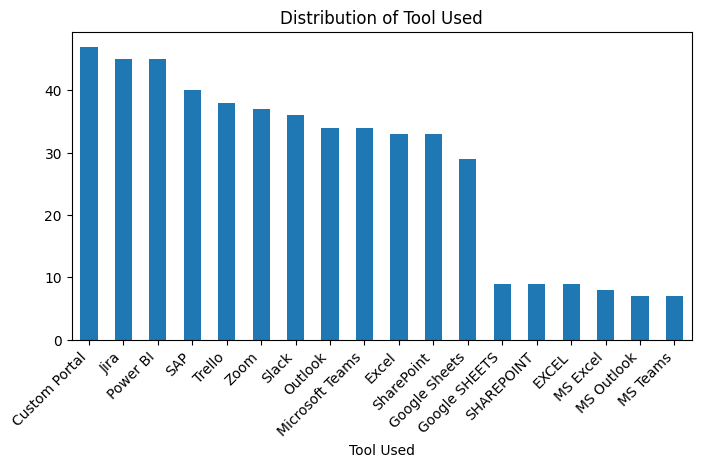

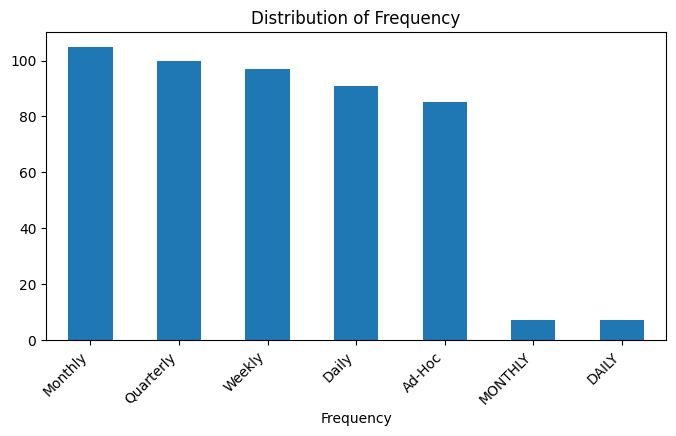

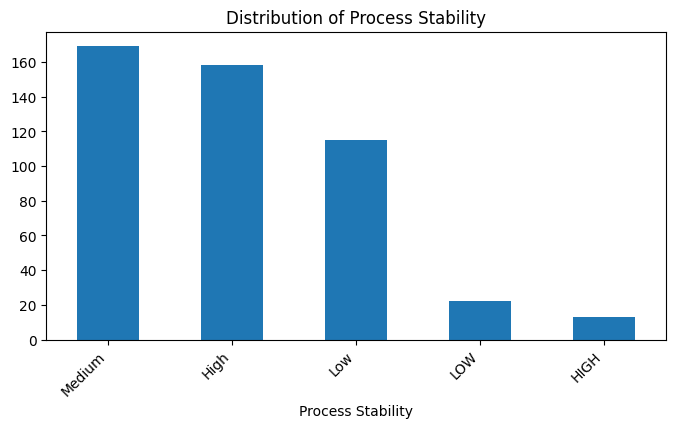

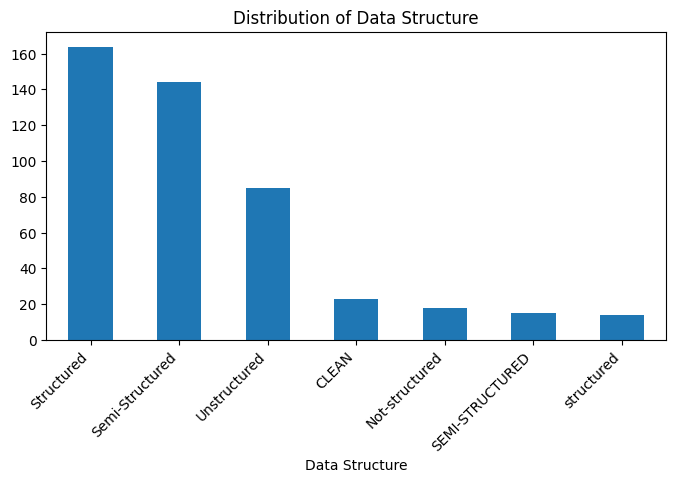

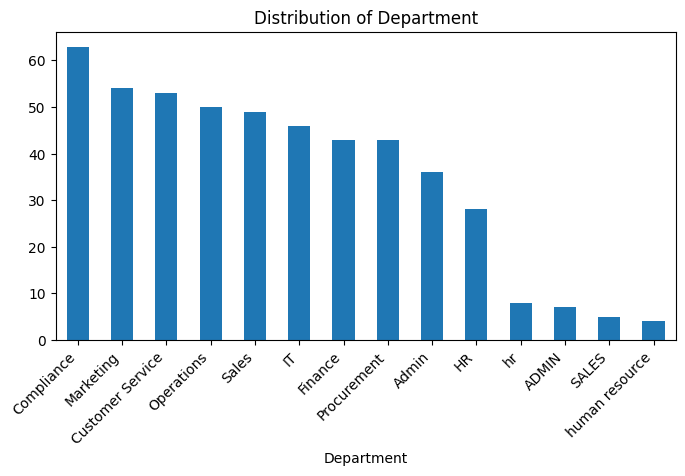

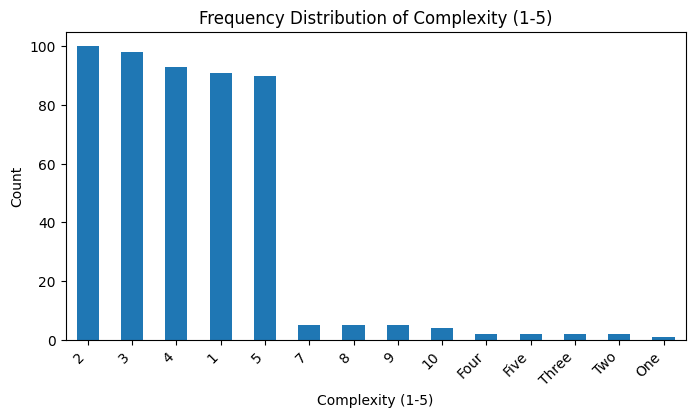

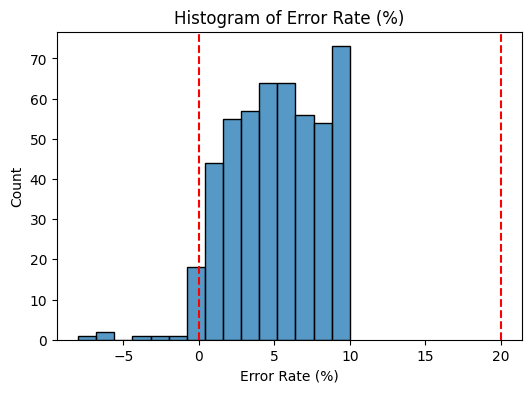

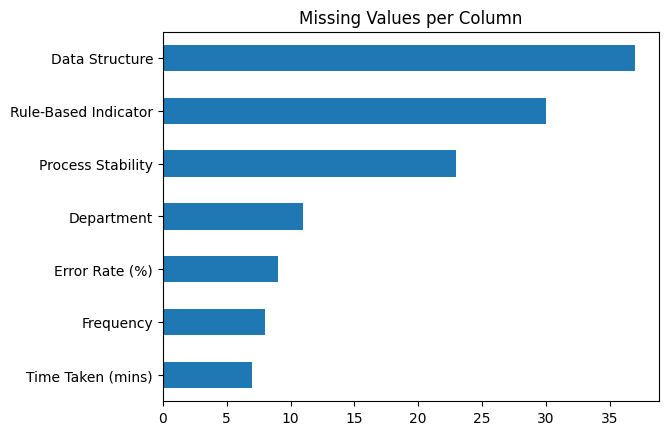

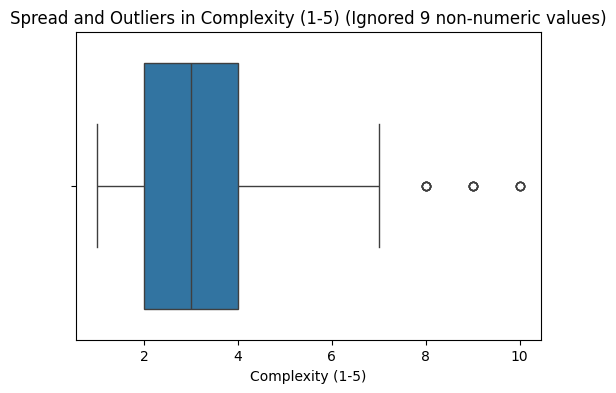

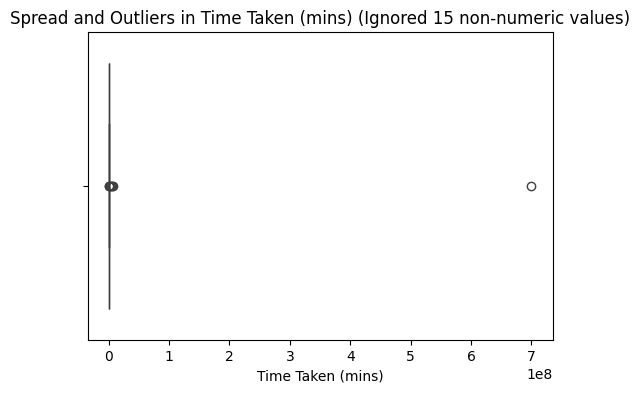

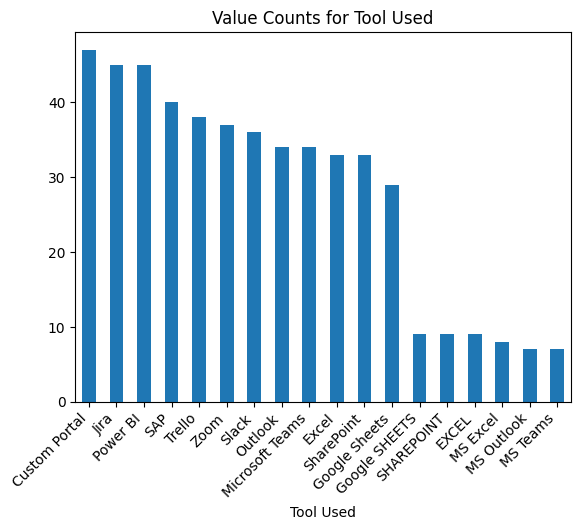

In [8]:
# === Graphical Analysis === #

def plot_barchart1(df, col):
    plot.figure(figsize=(8,4))
    df[col].value_counts().plot(kind='bar')
    plot.title(f"Distribution of {col}")
    plot.xticks(rotation=45, ha='right')
    plot.show()

def plot_barchart2(df, col):
    plot.figure(figsize=(8, 4))
    df[col].astype(str).value_counts().plot(kind='bar')
    plot.title(f"Frequency Distribution of {col}")
    plot.ylabel("Count")
    plot.xticks(rotation=45, ha='right')
    plot.show()

def plot_histogram(df, col, min_val=0, max_val=20):
    plot.figure(figsize=(6,4))
    sea.histplot(df[col], kde=False)
    plot.axvline(min_val, color='red', linestyle='--')
    plot.axvline(max_val, color='red', linestyle='--')
    plot.title(f"Histogram of {col}")
    plot.show()

def plot_missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values().plot(kind='barh')
    plot.title("Missing Values per Column")
    plot.show()

def plot_boxplot(df, col):
    numeric_series = pd.to_numeric(df[col], errors='coerce')
    dropped_count = numeric_series.isna().sum()
    
    if numeric_series.dropna().empty:
        print(f"Cannot plot outliers for '{col}': no numeric data available.")
        return
    
    plot.figure(figsize=(6, 4))
    sea.boxplot(x=numeric_series)
    plot.title(f"Spread and Outliers in {col} (Ignored {dropped_count} non-numeric values)")
    plot.show()

def plot_barchart3(df, col):
    df[col].value_counts().plot(kind='bar')
    plot.title(f"Value Counts for {col}")
    plot.xticks(rotation=45, ha='right')
    plot.show()

def graphical_analysis(df):
    plot_barchart1(df, "Tool Used")
    plot_barchart1(df, "Frequency")
    plot_barchart1(df, "Process Stability")
    plot_barchart1(df, "Data Structure")
    plot_barchart1(df, "Department")
    plot_barchart2(df, "Complexity (1-5)")
    plot_histogram(df, "Error Rate (%)")
    plot_missing_values(df)
    plot_boxplot(df, "Complexity (1-5)")
    plot_boxplot(df, "Time Taken (mins)")
    plot_barchart3(df, "Tool Used")

graphical_analysis(df_eda)

# === Data Exploration Ends Here === #